In [1]:
# %cd /content/drive/My\ Drive/Colab\ Notebooks

In [2]:
## COMP9517 Computer Vision Project 20T2
# code: Main program for the project
#
# Group C:
# Connor Baginski (z5207788)
# Bhumika Singhal (z5234799)
# Rishav Guha (z5294757)
# Amel Johny (z5294308)

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import os
import imutils
from processing import *
from network import Network

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from skimage.morphology import watershed, disk
from skimage.feature import peak_local_max
from skimage.filters import meijering

from scipy import ndimage as ndi

from cell_tracking.helpers import fi_list, find_centers, plot_rectangles,find_labels_Phc,find_labels_Fluo,print_tracks,put_text
from cell_tracking.pathTracking import PathTracker



def fi_list(path):
    """
    Return a sorted list of filenames in a given path
    """
    return sorted([os.path.join(path, f) for f in os.listdir(path)])

def plot_two_images(imgL, imgR, titleL, titleR):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(imgL, cmap='gray')
    plt.title(titleL)
    f.add_subplot(1,2, 2)
    plt.imshow(imgR, cmap='gray')
    plt.title(titleR)
    plt.show(block=True)

def custom_thresh(image):
    for r in range(image.shape[0]):
        for c in range(image.shape[1]):
            if image[r,c] > 0.05:
                image[r,c] = 255
            else:
                image[r,c] = 0

    return image

In [3]:
def detect_DIC():
    pathTracker = PathTracker()
    bounding_box_list = []
    
    for filename in fi_list('DIC-C2DH-HeLa/Sequence 2'):
        if not filename.endswith(".tif"):
            continue
        print(filename)
        image = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
        # Preprocessing
        image = equalize_clahe(image)
        x = torch.tensor(np.array([image.astype(np.float32)]))
        # Add a "Batch" dimension
        x = x.unsqueeze(0)
        
        # Load CNN models
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        net = Network()
        # TODO: CHANGE TO BEST MODEL
        net.load_state_dict(torch.load("CNN_min_loss_dic.pth", map_location=device))
#         net.load_state_dict(torch.load("CNN_max_score_dic.pth", map_location=device))
        
        with torch.no_grad():
            net.eval()

            # Generate cell mask and markers from image           
            output = net(x)
            markers = (output[0,0] > 0.5).int()
            cell_mask = (output[0,1] > 0.5).int()
            
#             # Plot output images
#             plt.imshow(image, cmap='gray')
#             plt.title("Input")
#             plt.show()
            
#             plot_two_images(cell_mask, markers, "Cell Mask", "Markers")
            
            # Postprocessing
            ws_labels = get_ws_from_markers(markers.numpy(), cell_mask.numpy(), 12)
            bound_box = get_bound_box_from_ws(image, ws_labels)
#             pimg(ws_labels)

            #find Center
            centers, boundingBoxes, circular, is_circular = find_centers(ws_labels,image)
#           pimg(ws_labels)
            number_of_cells_in_frame = len(centers)
            put_text(image, 10,50,"No of cells : {}".format(number_of_cells_in_frame))
            #update tracker with new positions
#             print(centers)
            pathTracker.update(image,centers, circular, is_circular, boundingBoxes)
            bounding_box_list.append(boundingBoxes)

            # print tracks
#             print_tracks(image, pathTracker, number_of_cells_in_frame)
#             plt.imshow(bound_box, cmap='gray')
#             plt.title("Cells with bounding box.")
#             plt.show()

    image_counter = 0
    for filename in fi_list('DIC-C2DH-HeLa/Sequence 2'):
        if not filename.endswith(".tif"):
            continue
        print(filename)
        image = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
        # Preprocessing
        image = equalize_clahe(image)
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        plot_rectangles(image,bounding_box_list,pathTracker.mito_frames, image_counter)
        image_counter +=1

    selected_cell = pathTracker.get_cell_from_center(3,np.array([488, 150]))
    print(selected_cell.positions, selected_cell.added_in_frame)
    
    print(get_cell_speed_at_frame(pathTracker, 4, np.array([173, 22])))
    print(get_cell_distance_at_frame(pathTracker, 4, np.array([173, 22])))
    print(get_cell_net_distance_at_frame(pathTracker, 4, np.array([173, 22])))
    print(get_cell_confinement_ratio_at_frame(pathTracker, 4, np.array([173, 22])))
    
    return

In [4]:
def detect_Fluo():
    pathTracker = PathTracker()
    
    for filename in fi_list('Fluo-N2DL-HeLa/Sequence 1'):
        if not filename.endswith(".tif"):
            continue
        print(filename)
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        # Threshold at value of 129
        thresh = cv2.threshold(image, 129, 255, cv2.THRESH_BINARY)[1]
        distance = ndi.distance_transform_edt(thresh)
        local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((10, 10)),
                                labels=thresh)
        markers, _ = ndi.label(local_maxi)
        ws_labels = watershed(-distance, markers, mask=thresh)
        
        #TODO: cite/recode following
        # loop over the unique labels returned by the Watershed
        # algorithm
        for label in np.unique(ws_labels):
            # if the label is zero, we are examining the 'background'
            # so simply ignore it
            if label == 0:
                continue

            # otherwise, allocate memory for the label region and draw
            # it on the mask
            mask = np.zeros(image.shape, dtype="uint8")
            mask[ws_labels == label] = 255

            # detect contours in the mask and grab the largest one
            cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
                cv2.CHAIN_APPROX_SIMPLE)
            cnts = imutils.grab_contours(cnts)
            c = max(cnts, key=cv2.contourArea)

            # draw a rectangle enclosing the object
            x,y,w,h = cv2.boundingRect(c)
            cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
#             cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        
        plt.gray()
        plt.imshow(thresh, cmap='gray')
        plt.show()
#         plt.imshow(image)
#         plt.show()
        centers, boundingBoxes = find_centers(ws_labels, image)
        number_of_cells_in_frame = len(centers)
        put_text(image, 10,50,"No of cells : {}".format(number_of_cells_in_frame))
        #update tracker with new positions
#             print(centers)
        pathTracker.update(image,centers)
        plot_rectangles(image,boundingBoxes)
        
        # print tracks
        print_tracks(image, pathTracker, number_of_cells_in_frame)

    return

def detect_PhC():
    pathTracker = PathTracker()
    
    for filename in fi_list(r'PhC-C2DL-PSC/Sequence 1'):
        if not filename.endswith(".tif"):
            continue
        print(filename)
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        
        # Preprocessing
        image = equalize_clahe(image)
        x = torch.tensor(np.array([image.astype(np.float32)]))
        # Add a "Batch" dimension
        x = x.unsqueeze(0)
        
        # Load CNN models
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        net = Network()
        # TODO: CHANGE TO BEST MODEL
        net.load_state_dict(torch.load("CNN_min_loss_phc.pth", map_location=device))
#         net.load_state_dict(torch.load("CNN_max_score_phc.pth", map_location=device))
        
        with torch.no_grad():
            net.eval()

            # Generate cell mask and markers from image           
            output = net(x)

            markers = (output[0,0] > 0.5).int()
            cell_mask = (output[0,1] > 0.5).int()
            
#             # Plot output images
#             plt.imshow(image, cmap='gray')
#             plt.title("Input")
#             plt.show()
            
#             plot_two_images(cell_mask, markers, "Cell Mask", "Markers")
            
            # Postprocessing
            ws_labels = get_ws_from_markers(markers.numpy(), cell_mask.numpy(), 0)
            bound_box = get_bound_box_from_ws(image, ws_labels)
#             pimg(ws_labels)

            centers, boundingBoxes = find_centers(ws_labels, image)
            number_of_cells_in_frame = len(centers)
            put_text(image, 10,50,"No of cells : {}".format(number_of_cells_in_frame))
            #update tracker with new positions
#             print(centers)
            pathTracker.update(image,centers)
            plot_rectangles(image,boundingBoxes)
            
            pimg(image)
            
            # print tracks 
            print_tracks(image, pathTracker, number_of_cells_in_frame)
            
#             plt.imshow(bound_box, cmap='gray')
#             plt.title("Cells with bounding box.")
#             plt.show()
            
    return
        
#         thresh = cv2.threshold(image, 162, 255, cv2.THRESH_BINARY)[1]
#         kernel = np.ones((4,4),np.uint8)
#         # Perform an erosion followed by dilation opening to remove noise
#         opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
#         distance = ndi.distance_transform_edt(opening)
#         local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((10, 10)),
#                                 labels=thresh)
#         markers, _ = ndi.label(local_maxi)
#         ws_labels = watershed(-distance, markers, mask=thresh)
        
#         #TODO: cite/recode following
#         # loop over the unique labels returned by the Watershed
#         # algorithm
#         for label in np.unique(ws_labels):
#             # if the label is zero, we are examining the 'background'
#             # so simply ignore it
#             if label == 0:
#                 continue

#             # otherwise, allocate memory for the label region and draw
#             # it on the mask
#             mask = np.zeros(image.shape, dtype="uint8")
#             mask[ws_labels == label] = 255

#             # detect contours in the mask and grab the largest one
#             cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
#                 cv2.CHAIN_APPROX_SIMPLE)
#             cnts = imutils.grab_contours(cnts)
#             c = max(cnts, key=cv2.contourArea)

#             # draw a rectangle enclosing the object
#             x,y,w,h = cv2.boundingRect(c)
#             cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
#             cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        
#         plt.imshow(image, cmap='gray')
#         plt.show()
#         plt.imshow(opening, cmap='gray')
#         plt.show()
#         plt.imshow(ws_labels, cmap='gray')
#         plt.show()
#     return

Choose a dataset.
1) DIC-C2DH-HeLa
2) Fluo-N2DL-HeLa
3) PhC-C2DL-PSC
> 1
DIC-C2DH-HeLa/Sequence 2\t000.tif


E:\Anaconda\envs\compvis\lib\site-packages\torch\nn\functional.py:2970: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
E:\Anaconda\envs\compvis\lib\site-packages\torch\nn\functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


DIC-C2DH-HeLa/Sequence 2\t001.tif
DIC-C2DH-HeLa/Sequence 2\t002.tif
DIC-C2DH-HeLa/Sequence 2\t003.tif
DIC-C2DH-HeLa/Sequence 2\t004.tif
DIC-C2DH-HeLa/Sequence 2\t005.tif
DIC-C2DH-HeLa/Sequence 2\t006.tif
DIC-C2DH-HeLa/Sequence 2\t007.tif
DIC-C2DH-HeLa/Sequence 2\t008.tif
DIC-C2DH-HeLa/Sequence 2\t009.tif
DIC-C2DH-HeLa/Sequence 2\t010.tif
DIC-C2DH-HeLa/Sequence 2\t000.tif
0 0 145 120
[0, 0, 145, 120]
[]
108 0 221 57
[108, 0, 221, 57]
[]
300 109 467 266
[300, 109, 467, 266]
[]
114 139 252 261
[114, 139, 252, 261]
[]
245 156 392 319
[245, 156, 392, 319]
[]
88 216 234 348
[88, 216, 234, 348]
[]
180 257 318 426
[180, 257, 318, 426]
[]
349 305 475 415
[349, 305, 475, 415]
[]
266 369 415 500
[266, 369, 415, 500]
[]
129 445 301 512
[129, 445, 301, 512]
[]
(512, 512, 3)


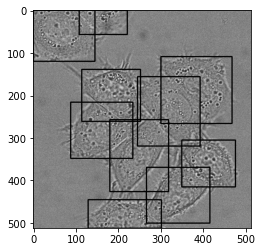

DIC-C2DH-HeLa/Sequence 2\t001.tif
0 0 236 112
[0, 0, 236, 112]
[]
301 106 467 256
[301, 106, 467, 256]
[]
124 134 262 290
[124, 134, 262, 290]
[]
256 159 394 315
[256, 159, 394, 315]
[]
99 204 213 344
[99, 204, 213, 344]
[]
179 259 315 438
[179, 259, 315, 438]
[]
358 306 481 417
[358, 306, 481, 417]
[]
281 361 420 486
[281, 361, 420, 486]
[]
135 428 303 512
[135, 428, 303, 512]
[]
(512, 512, 3)


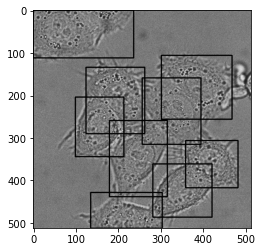

DIC-C2DH-HeLa/Sequence 2\t002.tif
0 0 153 113
[0, 0, 153, 113]
[]
117 0 233 59
[117, 0, 233, 59]
[]
313 107 452 255
[313, 107, 452, 255]
[]
122 137 264 286
[122, 137, 264, 286]
[]
249 157 398 312
[249, 157, 398, 312]
[]
441 158 512 234
[441, 158, 512, 234]
[]
92 198 215 340
[92, 198, 215, 340]
[]
171 257 325 433
[171, 257, 325, 433]
[]
368 298 478 415
[368, 298, 478, 415]
[]
290 355 420 481
[290, 355, 420, 481]
[]
131 430 309 512
[131, 430, 309, 512]
[]
(512, 512, 3)


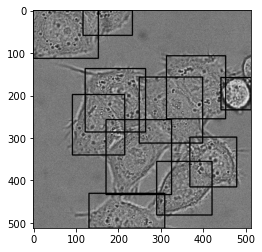

DIC-C2DH-HeLa/Sequence 2\t003.tif
0 0 148 117
[0, 0, 148, 117]
[]
111 0 236 71
[111, 0, 236, 71]
[]
456 113 512 189
[456, 113, 512, 189]
[]
317 118 471 248
[317, 118, 471, 248]
[]
123 145 274 290
[123, 145, 274, 290]
[]
256 161 393 321
[256, 161, 393, 321]
[]
88 195 192 344
[88, 195, 192, 344]
[]
159 269 320 449
[159, 269, 320, 449]
[]
385 303 484 408
[385, 303, 484, 408]
[]
278 349 435 506
[278, 349, 435, 506]
[]
133 434 301 512
[133, 434, 301, 512]
[]
(512, 512, 3)


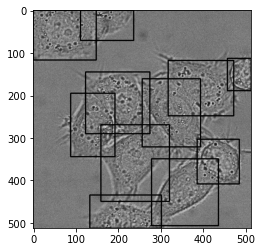

DIC-C2DH-HeLa/Sequence 2\t004.tif
0 0 151 113
[0, 0, 151, 113]
[]
107 0 230 76
[107, 0, 230, 76]
[]
480 71 512 145
[480, 71, 512, 145]
[]
315 119 478 261
[315, 119, 478, 261]
[]
128 147 274 292
[128, 147, 274, 292]
[]
258 159 402 317
[258, 159, 402, 317]
[]
71 197 207 341
[71, 197, 207, 341]
[]
166 270 314 448
[166, 270, 314, 448]
[]
384 301 484 406
[384, 301, 484, 406]
[]
288 356 425 484
[288, 356, 425, 484]
[]
133 451 304 512
[133, 451, 304, 512]
[]
(512, 512, 3)


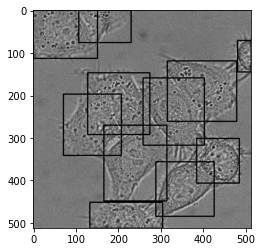

DIC-C2DH-HeLa/Sequence 2\t005.tif
0 0 139 123
[0, 0, 139, 123]
[]
96 0 240 63
[96, 0, 240, 63]
[]
479 64 512 147
[479, 64, 512, 147]
[]
312 123 508 263
[312, 123, 508, 263]
[]
126 148 276 300
[126, 148, 276, 300]
[]
258 168 392 327
[258, 168, 392, 327]
[]
95 206 215 351
[95, 206, 215, 351]
[]
178 271 315 440
[178, 271, 315, 440]
[]
375 312 483 413
[375, 312, 483, 413]
[]
286 363 422 497
[286, 363, 422, 497]
[]
134 459 297 512
[134, 459, 297, 512]
[]
(512, 512, 3)


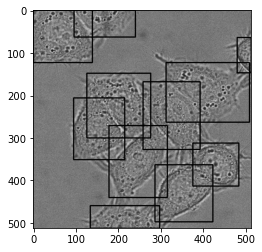

DIC-C2DH-HeLa/Sequence 2\t006.tif
0 0 149 120
[0, 0, 149, 120]
[]
96 0 238 74
[96, 0, 238, 74]
[]
463 51 512 129
[463, 51, 512, 129]
[]
312 116 512 257
[312, 116, 512, 257]
[]
122 148 268 297
[122, 148, 268, 297]
[]
253 166 400 320
[253, 166, 400, 320]
[]
86 209 225 346
[86, 209, 225, 346]
[]
152 267 310 440
[152, 267, 310, 440]
[]
354 311 482 417
[354, 311, 482, 417]
[]
286 353 429 502
[286, 353, 429, 502]
[]
133 459 300 512
[133, 459, 300, 512]
[]
(512, 512, 3)


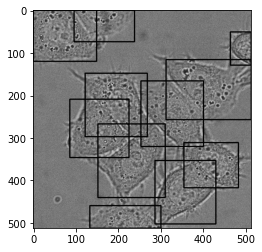

DIC-C2DH-HeLa/Sequence 2\t007.tif
0 0 144 108
[0, 0, 144, 108]
[]
468 37 512 111
[468, 37, 512, 111]
[]
310 95 485 255
[310, 95, 485, 255]
[]
122 136 259 267
[122, 136, 259, 267]
[]
259 165 400 302
[259, 165, 400, 302]
[]
96 202 238 351
[96, 202, 238, 351]
[]
139 243 310 429
[139, 243, 310, 429]
[]
336 302 482 405
[336, 302, 482, 405]
[]
283 355 430 487
[283, 355, 430, 487]
[]
141 441 316 512
[141, 441, 316, 512]
[]
(512, 512, 3)


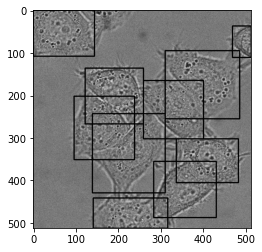

DIC-C2DH-HeLa/Sequence 2\t008.tif
0 0 143 107
[0, 0, 143, 107]
[]
302 89 502 248
[302, 89, 502, 248]
[]
119 135 267 259
[119, 135, 267, 259]
[]
252 156 401 303
[252, 156, 401, 303]
[]
89 203 228 339
[89, 203, 228, 339]
[]
146 244 311 426
[146, 244, 311, 426]
[]
338 297 477 405
[338, 297, 477, 405]
[]
271 362 429 498
[271, 362, 429, 498]
[]
132 424 289 512
[132, 424, 289, 512]
[]
(512, 512, 3)


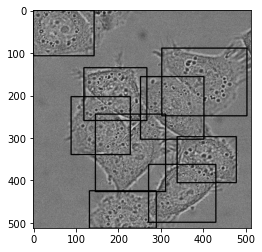

DIC-C2DH-HeLa/Sequence 2\t009.tif
0 0 142 111
[0, 0, 142, 111]
[]
316 89 509 248
[316, 89, 509, 248]
[]
115 139 273 268
[115, 139, 273, 268]
[]
254 149 407 307
[254, 149, 407, 307]
[]
87 195 230 340
[87, 195, 230, 340]
[]
145 254 322 425
[145, 254, 322, 425]
[]
353 274 475 405
[353, 274, 475, 405]
[]
277 349 428 490
[277, 349, 428, 490]
[]
132 441 290 512
[132, 441, 290, 512]
[]
(512, 512, 3)


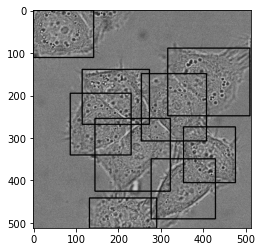

DIC-C2DH-HeLa/Sequence 2\t010.tif
0 0 143 112
[0, 0, 143, 112]


IndexError: list index out of range

In [5]:
def main():
    select = int(input("Choose a dataset.\n1) DIC-C2DH-HeLa\n2) Fluo-N2DL-HeLa\n3) PhC-C2DL-PSC\n> "))

    if select == 1:
        detect_DIC()
    elif select == 2:
        detect_Fluo()
    elif select == 3:
        detect_PhC()
    else:
        print("Invalid input.")

if __name__ == '__main__':
    main()